In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import geopandas as geopd
import contextily as ctx
import shapely as shp
import cartopy

In [2]:
#Einlesen des Datensatzes und vorbereiten zur weiteren Nutzung 
header = ['GW-Nummer','Stadt','Lat','Lon']
data = pd.read_csv('Pegel_data.csv',sep=';', encoding='cp1252', names=header)
depth = pd.read_csv("GW_depth.csv", delimiter=',')
data = pd.merge(data,depth,how='left', on='GW-Nummer')
data = data.groupby("GW-Nummer").mean()
data = data.dropna()
data.columns = ['Lat','Lon', 'GWHoehe']

Text(0.5, 1.0, 'Übersichtskarte aller Messstellen')

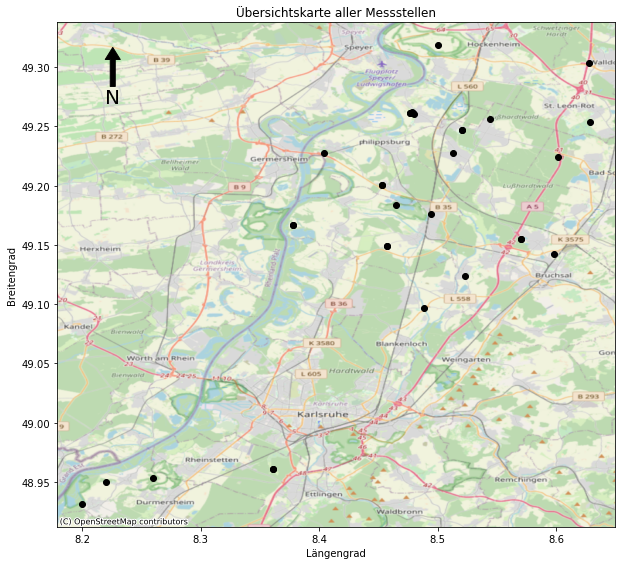

In [3]:
#Geometrien erstellen
geometry =[]
for index, row in data.iterrows():
    geometry.append(shp.geometry.Point(row.Lon, row.Lat))
    
#Ins geopandas Format speichern
gdf = geopd.GeoDataFrame(data, crs='epsg:4326', geometry=geometry)

#speichern als Shape-Datei
gdf.to_file('Pegel_data.shp')

#Karte erstellen

fig, ax = plt.subplots(1,1, figsize= (10,10))

monitoring = geopd.read_file('Pegel_data.shp')

monitoring.plot(ax=ax, marker='o', c='k')
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
x, y, arrow_length = 0.1, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
ax.set_xlabel('Längengrad')
ax.set_ylabel('Breitengrad')
ax.set_title('Übersichtskarte aller Messstellen')

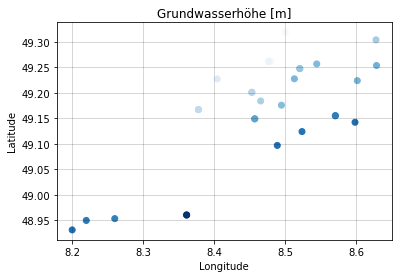

In [4]:
#Plot der Koordinaten, um generellen Überblick zu den GWT zu erhalten 
fig = plt.figure(1, figsize=(6, 4))
ax = fig.add_subplot(1,1,1)

plt.scatter(data.Lon, data.Lat, c=data.GWHoehe, cmap='Blues')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grundwasserhöhe [m]')
plt.grid(c='k', alpha=0.2)
plt.show()

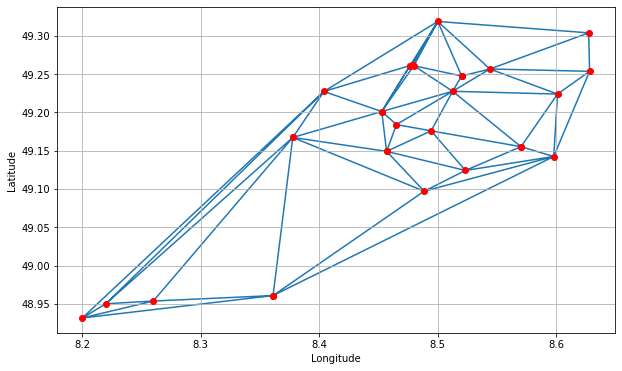

In [5]:
#Erzeugen von einem Objekt mit einer Delaunay-Triangulation 
from scipy.spatial import Delaunay

points = data[['Lon','Lat']].values
tri = Delaunay(points)

plt.figure(5, figsize=(10,6))
plt.triplot(data.Lon, data.Lat)
plt.plot(data.Lon, data.Lat, "or")
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

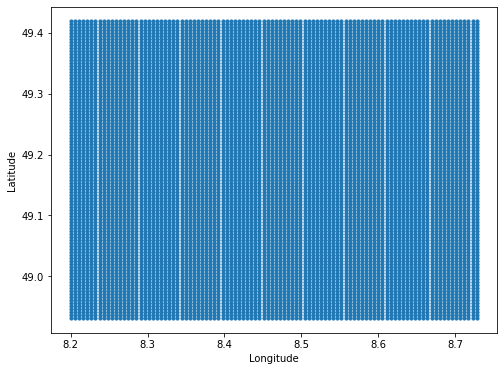

In [6]:
# Erzeugen eines regelmäßiges Grid von Datenpunkten 
# Definition der Ausdehnung des Bereichs der alle Messpunkte einschließt (+kleinen Puffer)
extent = x_min, x_max, y_min, y_max = [data.Lon.min(), data.Lon.max()+0.1,
                                       data.Lat.min(), data.Lat.max()+0.1]

#Erstellen von zwei Arrays für die x- und y-Koordinaten der Gridpunkte
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

plt.figure(2, figsize=(8,6))
plt.scatter(grid_x, grid_y, s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

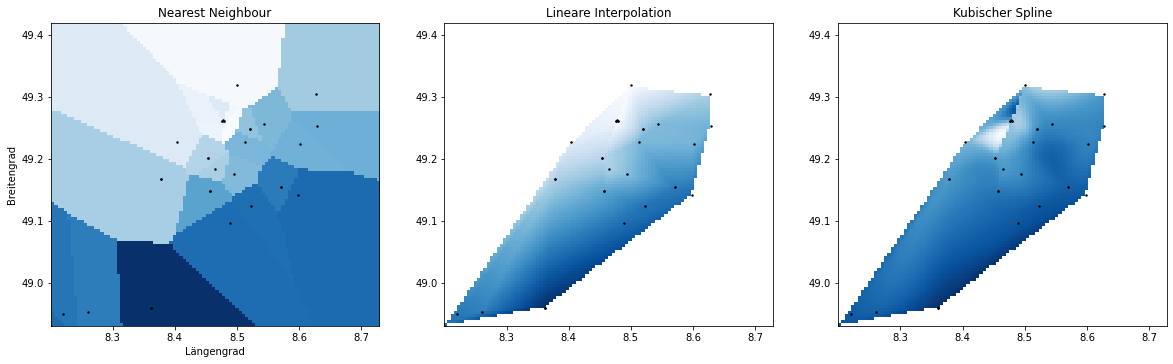

In [7]:
from scipy.interpolate import griddata


#Temperaturdaten interpolieren mit drei verschiedenen Interpolationsmethoden
grid_z0 = griddata(points, data.GWHoehe.values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, data.GWHoehe.values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, data.GWHoehe.values, (grid_x, grid_y), method='cubic')

#Plotten der drei Interpolationen
fig, axs = plt.subplots(ncols=3, figsize=(20,10))

ax = axs[0]
ax.imshow(grid_z0.T, origin='lower', extent=extent, cmap='Blues')
ax.scatter(data.Lon, data.Lat, s=2, c='k')
ax.set_title('Nearest Neighbour')
ax.set_xlabel('Längengrad')
ax.set_ylabel('Breitengrad')

ax = axs[1]
ax.imshow(grid_z1.T, origin='lower', extent=extent, cmap='Blues')
ax.scatter(data.Lon, data.Lat, s=2, c='k')
ax.set_title('Lineare Interpolation')

ax = axs[2]
ax.imshow(grid_z2.T, origin='lower', extent=extent, cmap='Blues')
ax.scatter(data.Lon, data.Lat, s=2, c='k')
ax.set_title('Kubischer Spline')

plt.show()

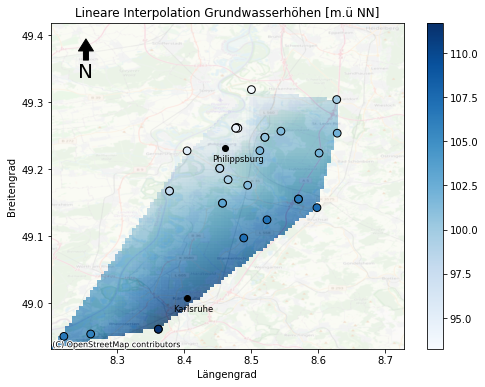

In [8]:
#Auswahl einer geeigneten Interpolationsmethode und adden zu einer Karte 

fig = plt.figure(3, figsize=(8,6))
ax = fig.add_subplot()
c1 = ax.imshow(grid_z1.T, origin='lower', extent=extent, cmap='Blues')
c2 = plt.scatter(data.Lon, data.Lat,c=data.GWHoehe, s=60, zorder=1,edgecolor='k',cmap = 'Blues')
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.3)
x, y, arrow_length = 0.1, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
def plot_cities(ax):
    lats = [49.006889,49.2317]
    lons = [8.403653, 8.46074]
    cities = ['Karlsruhe','Philippsburg']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'o', zorder=4,color='k')
        ax.text(lon-0.02, lat-0.02 , city, fontsize='small')
plot_cities(ax)
plt.colorbar(c1, shrink=1)
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.title('Lineare Interpolation Grundwasserhöhen [m.ü NN]')
plt.show()

In [9]:
from scipy.interpolate import Rbf
#Um eine Rbf Interpolation zu erstellen, müssen die doppelten Breitengradwerte bereinigt werden
data= data.drop_duplicates('Lat')

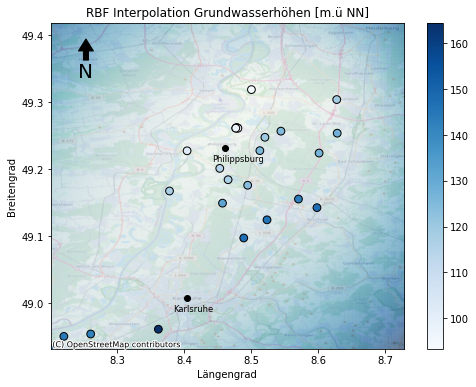

In [11]:
#Interpolation mit Radialen Basisfunktionen

#Definition von einem Interpolationsobjekt
rbfi = Rbf(data.Lon, data.Lat, data.GWHoehe, function='linear')
di = rbfi(grid_x, grid_y)

#plotten der Interpolation mit Karte
fig = plt.figure(3, figsize=(8,6))
ax = fig.add_subplot()
c1 = ax.imshow(di.T, origin='lower', extent=extent, cmap='Blues')
c2 = plt.scatter(data.Lon, data.Lat, s=60, c=data.GWHoehe, edgecolor='k',  cmap = 'Blues')
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.4)
x, y, arrow_length = 0.1, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
def plot_cities(ax):
    # lat/lon Koordainaten zwei Städte in BW
    lats = [49.006889,49.2317]
    lons = [8.403653, 8.46074]
    cities = ['Karlsruhe','Philippsburg']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'o', zorder=4,color='k')
        ax.text(lon-0.02, lat-0.02 , city, fontsize='small')
plot_cities(ax)
plt.colorbar(c1, shrink=1)
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.title('RBF Interpolation Grundwasserhöhen [m.ü NN]')
plt.show()